In [1]:
import numpy as np
import operator
import logging
import time

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass, matched_filter, sigma
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform

import optuna

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["figure.autolayout"] = True

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptunaJax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class NeedsInvestigatingCallback(object):
    """A callback for Optuna which identifies potential events."""

    def __init__(self, early_stopping_rounds: int, snr_threshold: int, direction: str = "minimize") -> None:
        self.snr_threshold = snr_threshold
        self.early_stopping_rounds = early_stopping_rounds
        
        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Goes onto Stocastic Gradient Descent."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._score >= self.snr_threshold:
            if self._iter >= self.early_stopping_rounds:
                study.stop()
                print(study.best_params)

In [3]:
def confirmed_gw_timeseries(event, detector):
    merger = Merger(event)

    # Get the data from the Hanford detector
    strain = merger.strain(detector)

    # Remove the low frequency content and downsample the data to 2048Hz
    strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)

    # Remove 2 seconds of data from both the beginning and end
    conditioned = strain.crop(2, 2)
    
    return conditioned

def confirmed_gw_psd(conditioned):
    psd = conditioned.psd(4)

    psd = interpolate(psd, conditioned.delta_f)

    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=15)
    return psd


In [4]:
def objective(trial):
    m1 = trial.suggest_float('m1', 2, 100, step=0.000001)
    m2 = trial.suggest_float('m2', 2, 100, step=0.000001)
    #s1 = trial.suggest_float('s1', -0.99, 0.99, step=0.000001)
    #s2 = trial.suggest_float('s2', -0.99, 0.99, step=0.000001)
    #hp, hc = get_td_waveform(approximant="IMRPhenomXAS", mass1=m1, mass2=m2, spin1z=s1, spin2z=s2, delta_t=conditioned.delta_t,f_lower=20)
    mass1_list.append(m1)
    mass2_list.append(m2)
    conditioned = confirmed_gw_timeseries(event, detector='L1')
    psd = confirmed_gw_psd(conditioned)
    f_conditioned = conditioned.to_frequencyseries()
    template, hc = get_fd_waveform(approximant="IMRPhenomXAS", mass1=m1, mass2=m2, delta_f=conditioned.delta_f, f_lower=20)
    template.resize(len(psd))
    snr = matched_filter(template, f_conditioned, psd=psd, low_frequency_cutoff=20)
    snr = snr.crop(2 + 4, 2)
    peak = abs(snr).numpy().argmax()
    snrp = abs(snr[peak])
    snr_list.append(float(snrp))
    return float(snrp)

In [5]:
#Events = ["GW150914", "GW151012", "GW151226", "GW170104", "GW170608", "GW170729", "GW170809", "GW170814", "GW170817", "GW170818", "GW170823"]

Events = ["GW151012"]

In [6]:
for event in Events: 
    snr_list = []
    mass1_list = []
    mass2_list = []
    start_time = time.time()
    #optuna.logging.disable_default_handler()
    direction="maximize"
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction=direction)
    needs_to_be_investigated = NeedsInvestigatingCallback(300, snr_threshold=6, direction=direction)
    study.optimize(objective, callbacks=[needs_to_be_investigated], n_trials=300)
    

[I 2023-05-11 16:37:47,918] A new study created in memory with name: no-name-261c4ddf-ed77-41a3-9fbe-f18db9df6c9f
[I 2023-05-11 16:37:48,372] Trial 0 finished with value: 4.0010459723339356 and parameters: {'m1': 41.12173, 'm2': 95.556927}. Best is trial 0 with value: 4.0010459723339356.
[I 2023-05-11 16:37:48,704] Trial 1 finished with value: 4.325477546098844 and parameters: {'m1': 24.400548999999998, 'm2': 61.389075999999996}. Best is trial 1 with value: 4.325477546098844.
[I 2023-05-11 16:37:49,087] Trial 2 finished with value: 4.758482766402572 and parameters: {'m1': 6.948516, 'm2': 51.774587999999994}. Best is trial 2 with value: 4.758482766402572.
[I 2023-05-11 16:37:49,412] Trial 3 finished with value: 4.124676799434622 and parameters: {'m1': 46.197955, 'm2': 87.779675}. Best is trial 2 with value: 4.758482766402572.
[I 2023-05-11 16:37:49,738] Trial 4 finished with value: 4.21409717289727 and parameters: {'m1': 50.469986999999996, 'm2': 25.760227}. Best is trial 2 with value: 

IndexError: list index out of range

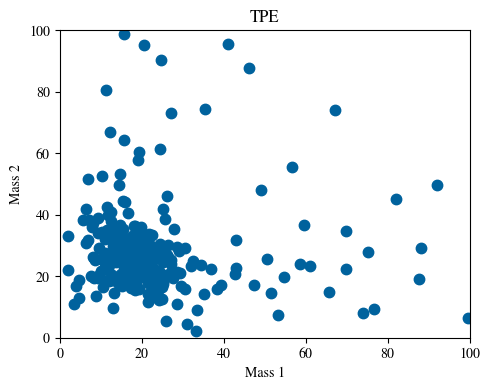

In [7]:
fig = plt.figure(figsize=(5, 4), dpi=100) 
ax = plt.axes(xlim=(0, 100), ylim=(0, 100)) 
line, = ax.plot([], [], lw=2, marker ='.', linestyle='None', markersize=15, color='#00629d') 

# initialization function 
def init(): 
	# creating an empty plot/frame 
	line.set_data([], []) 
	return line, 

# lists to store x and y axis points 
xdata, ydata = [], [] 

# animation function 
def animate(i):
    xdata.append(mass1_list[i]) 
    ydata.append(mass2_list[i]) 
    line.set_data(xdata, ydata)
    return line, 
	
# setting a title for the plot 
plt.title('TPE') 
plt.xlabel('Mass 1')
plt.ylabel('Mass 2')

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, 
							frames=500, interval=len(mass1_list), blit=True) 

# save the animation as mp4 video file 
anim.save('GWtunaQMC.gif', writer='imagemagick', dpi=150) 


/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptunaJax/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


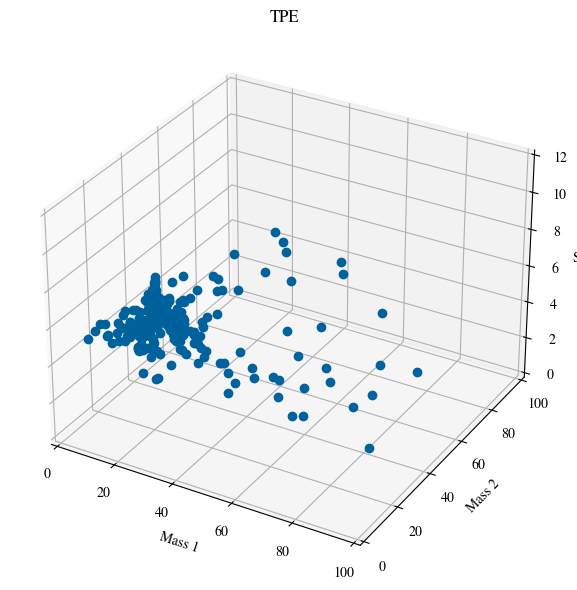

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Setting up Data Set for Animation
dataSet = np.array([mass1_list, mass2_list, snr_list])  # Combining our position coordinates
numDataPoints = len(mass1_list)

def animate_func(num):
    ax.clear()  # Clears the figure to update the line, point,   
                # title, and axes
    # Updating Trajectory Line (num+1 due to Python indexing)
    ax.plot3D(dataSet[0, :num+1], dataSet[1, :num+1], 
              dataSet[2, :num+1], c='#00629d',  marker='o', linestyle='None')
    # Updating Point Location 
    ax.scatter(dataSet[0, num], dataSet[1, num], dataSet[2, num], 
               c='#00629d', marker='o')
    # Adding Constant Origin
    #ax.plot3D(dataSet[0, 0], dataSet[1, 0], dataSet[2, 0],     
    #           c='black', marker='o')
    # Setting Axes Limits
    ax.set_xlim3d([0, 100])
    ax.set_ylim3d([0, 100])
    ax.set_zlim3d([0, 12])

    # Adding Figure Labels
    ax.set_title('TPE')
    ax.set_xlabel('Mass 1')
    ax.set_ylabel('Mass 2')
    ax.set_zlabel('SNR')

# Plotting the Animation
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = plt.axes(projection='3d')
line_ani = animation.FuncAnimation(fig, animate_func, interval=100,   
                                   frames=numDataPoints)

# save the animation as mp4 video file 
line_ani.save('3D.gif', writer='imagemagick') 
plt.show()